In [112]:
# imports
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import advertools as adv

In [56]:
# constants
LOC_DATA = "./data"
CHAT_FILENAME = "/chat_{}.txt"

MEDIA = 'media_shared'
DELETED = 'deleted_message'
CELINE = 'Celine'
SAM = 'Sam'

EN = 'EN'
FR = 'FR'
OTHER = 'other'

emoji_pat = r'(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])'

what_eng = r'(\d+(?:/|-)\d+(?:/|-)\d+, \d+:\d+\d+ [A-Za-z\.]*) - (.*?): (.*)'
date_form1 = re.compile('(\d+/\d+/\d+, \d+:\d+\d+ [A-Z]*)')
date_form2 = re.compile('(\d+\-\d+-\d+, \d+:\d+\d+ [a-z\.]*)')

what_fr = r'(\d+.\d+.\d+ à \d+:\d+\d+ [a-z\.\’ ]*) - (.*?): (.*)'
what_pat = re.compile('(?:%s)|(?:%s)' % (what_eng, what_fr))
what_pat = what_eng

col_chat = ['timestamp',  'name', 'msg']
df_col = col_chat + ['time', 'date', 'msg_len']

bar_size = (16, 7)

In [57]:
def to_df(msg):
    h = pd.DataFrame(msg, columns=col_chat)
    h['timestamp'] = h['timestamp'].str.upper()
    h['timestamp'] = h['timestamp'].str.replace('.', '')
    h['datetime'] = pd.to_datetime(h['timestamp'], format="%d/%m/%y, %I:%M %p", errors='coerce')
    h.datetime.update(pd.to_datetime(h[h.datetime.isnull()].timestamp, errors='coerce', yearfirst=False))
    h['date'] = h['datetime'].dt.date
    h['time'] = h['datetime'].dt.time
    h['msg_len'] = h['msg'].str.replace('\n', '').str.len()
    h['name'] = h['name'].str.replace('Celine.*', CELINE)
    h['name'] = h['name'].str.replace('Sam.*', SAM)
    h['msg'] = h['msg'].replace('<Media omitted>', MEDIA)
    h['msg'] = h['msg'].replace('This message was deleted', DELETED)
    return h

def read_whatsapp(file_name):
    with open(filename, encoding='utf-8') as f:
        messages = re.findall(what_pat, f.read())
        f.close()
        
    return to_df(messages)

In [58]:
# read txt files
df = pd.DataFrame(columns=col_chat)
for i in range(5):
    filename = LOC_DATA + CHAT_FILENAME.format(i)
    print(filename)
    tmp = read_whatsapp(filename)
    print(tmp.count())
    df = pd.concat([df, tmp], axis=0, ignore_index=True, sort=True)

./data/chat_0.txt
timestamp    7808
name         7808
msg          7808
datetime     7808
date         7808
time         7808
msg_len      7808
dtype: int64
./data/chat_1.txt
timestamp    19781
name         19781
msg          19781
datetime     19781
date         19781
time         19781
msg_len      19781
dtype: int64
./data/chat_2.txt
timestamp    5
name         5
msg          5
datetime     5
date         5
time         5
msg_len      5
dtype: int64
./data/chat_3.txt
timestamp    3504
name         3504
msg          3504
datetime     3504
date         3504
time         3504
msg_len      3504
dtype: int64
./data/chat_4.txt
timestamp    39999
name         39999
msg          39999
datetime     39999
date         39999
time         39999
msg_len      39999
dtype: int64


In [59]:
df[df.datetime.isnull()].head()

,date,datetime,msg,msg_len,name,time,timestamp


In [60]:
df.dtypes

date                 object
datetime     datetime64[ns]
msg                  object
msg_len             float64
name                 object
time                 object
timestamp            object
dtype: object

# Analysis
## Sam vs Celine

In [61]:
def agg_by_month(df, groups, agg):
    per = df.datetime.dt.to_period("M")
    groupby_list = [per]
    for group in groups:
        groupby_list.append(group)
    new_df = df.groupby(groupby_list).agg(agg).reset_index()
    
    return new_df

agg = {
        'msg': ['count'],
        'msg_len': ['sum', 'mean', 'median']
    }
df_agg = agg_by_month(df, ['name'], agg)
df_agg.head()

datetime    name   msg  msg_len                  
                   count      sum       mean median
0  2018-01  Celine    82   4254.0  51.878049   42.0
1  2018-01     Sam    97   5170.0  53.298969   43.0
2  2018-02  Celine   178  10298.0  57.853933   46.0
3  2018-02     Sam   228  12443.0  54.574561   44.0
4  2018-03  Celine   127   6961.0  54.811024   46.0

Sam and Celine met in mid September. The first message was sent by Sam:
### "Heyo"
to let Celine know where he would be going to eat lunch, which Celine replied with:
### "Coming! There's so many ppl, so I'll pay later."
What she was going buy? Who knows?

Celine and Sam were on the same continent between Sept 2018 - Jan 2019, and started dating mid Dec 2018. The decline in messages in Jan 2019 can be explained by the fact that they were actually hanging out together, thus no messages were necessary. This occurs again in Aug 2018, Nov 2020 and a little in Nov 2019.

In [62]:
colors = ["#FF7352", "#BBDE66"]
sns.set_palette(sns.color_palette(colors))

Text(0, 0.5, 'Number of Messages')

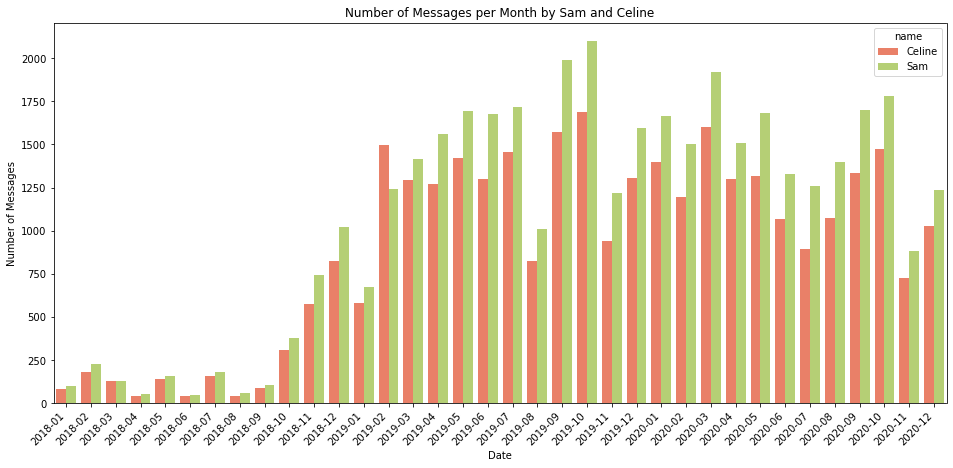

In [78]:
plt.figure(figsize=bar_size)
bplot = sns.barplot(y=('msg', 'count'), hue='name', x='datetime', data=df_agg)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
bplot.set_title('Number of Messages per Month by Sam and Celine')
bplot.set_xlabel('Date')
bplot.set_ylabel('Number of Messages')

## Length of Messages
Although the number of messages vary depending on the events that occur in their lives, the length of the messages stay relatively consistent and actually have downward trend with a plateau at the end. Perhaps, they've found a good balance and less words are needed convey their message.

On average, Sam sends more messages than Celine, and with more detail. On average 95 messages per day are exchanged between Celine and Sam and generally the most number of messages are excchanged on Friday.

Text(0, 0.5, 'Message Length')

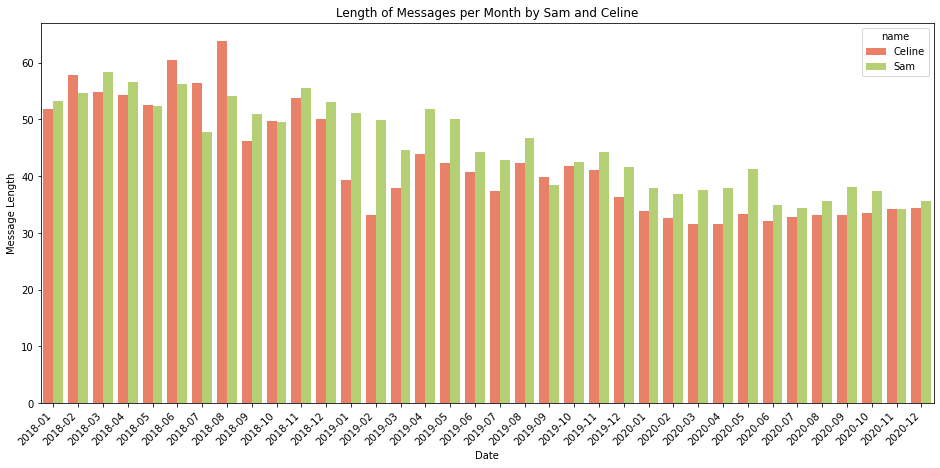

In [77]:
plt.figure(figsize=bar_size)
bplot = sns.barplot(y=('msg_len', 'mean'), hue='name', x='datetime', data=df_agg)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
bplot.set_title('Length of Messages per Month by Sam and Celine')
bplot.set_xlabel('Date')
bplot.set_ylabel('Message Length')

In [87]:
def agg_by_day(df):
    per = df.datetime.dt.to_period("D")
    new_df = df.groupby(
        [
            df['datetime'].dt.date,
            df['weekday']
        ]).agg({
        'msg': ['count']
    }).reset_index()
    
    return new_df

def agg_by_weekday(df):
    return df.groupby(
        [
            df['weekday'],
        ]
    ).agg({
        ('msg', 'count'): ['mean']
    }).reset_index()

dotw = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_day = df
df_day['weekday'] = df['datetime'].dt.day_name()
df_day = agg_by_day(df_day)
df_weekday = agg_by_weekday(df_day)
# Average number of messages per week
avg_msg_week = df_weekday[('msg', 'count', 'mean')].mean()
print('Average number of messages per week : {:.4f}'.format(avg_msg_week))
# Day of week most messages exchanged
max_msg_weekday = df_weekday.loc[df_agg2[('msg', 'count', 'mean')].idxmax(), 'weekday']
print('Most number of messages exchanged on : {}'.format(max_msg_weekday))

Average number of messages per week : 95.1463
Most number of messages exchanged on :       Thursday
Name: 4, dtype: object


Text(0, 0.5, 'Day of the Week')

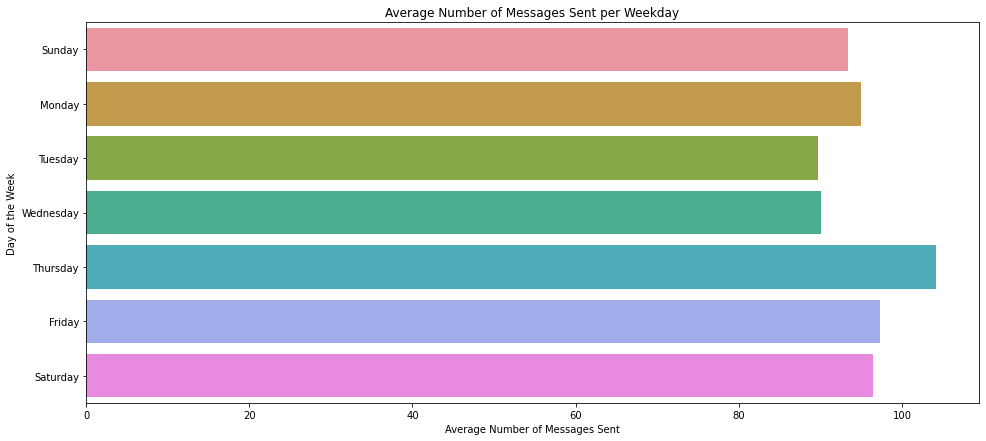

In [91]:
plt.figure(figsize=(16,7))
bplot = sns.barplot(x=('msg', 'count', 'mean'), y='weekday', data=df_weekday, order=dotw)
bplot.set_title('Average Number of Messages Sent per Weekday')
bplot.set_xlabel('Average Number of Messages Sent')
bplot.set_ylabel('Day of the Week')

## Language
Celine and Sam like to talk in French or English, although English is still used most often, they have made an effort to teach Celine French as shown by the increase of French messages throughout their relationship. Other categorized messages are due to errors in classifying the language, media type message or the text was deleted.

In [89]:
def fr_or_eng(m):
    if m == MEDIA or m == DELETED:
        return OTHER
    try:
        lang = detect(m)
        if lang == 'en':
            return EN
        else:
            return FR
    except:
        return OTHER

pickle_file = 'df_lang.pkl'
if os.path.isfile(pickle_file):
    df_lang = pd.read_pickle(pickle_file)
else:
    df_lang = df
    df_lang['lang'] = df_lang.msg.apply(fr_or_eng)
    df_lang.to_pickle(pickle_file)
df_lang.head()

,date,datetime,msg,msg_len,name,time,timestamp,weekday,lang
0,2018-09-26,2018-09-26 12:17:00,Heyo,4.0,Celine,12:17:00,"9/26/18, 12:17 PM",Wednesday,EN
1,2018-09-26,2018-09-26 12:18:00,l'Ornithorynque is where I'm going to eat,41.0,Sam,12:18:00,"9/26/18, 12:18 PM",Wednesday,EN
2,2018-09-26,2018-09-26 12:27:00,"Coming! There's so many ppl, so I'll pay later",46.0,Celine,12:27:00,"9/26/18, 12:27 PM",Wednesday,EN
3,2018-09-26,2018-09-26 21:40:00,http://aumc.epfl.ch/index.php/les-salles-de-mu...,64.0,Sam,21:40:00,"9/26/18, 9:40 PM",Wednesday,other
4,2018-09-26,2018-09-26 21:40:00,This is the music association I was talking about,49.0,Sam,21:40:00,"9/26/18, 9:40 PM",Wednesday,EN


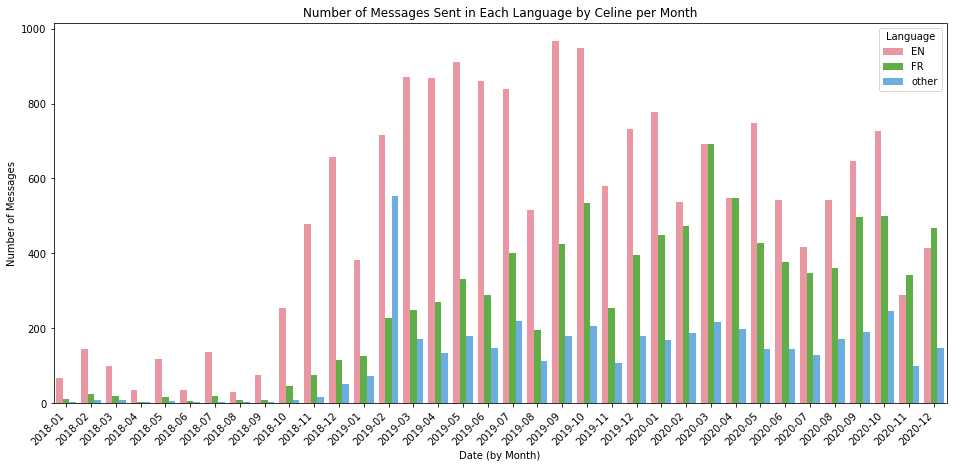

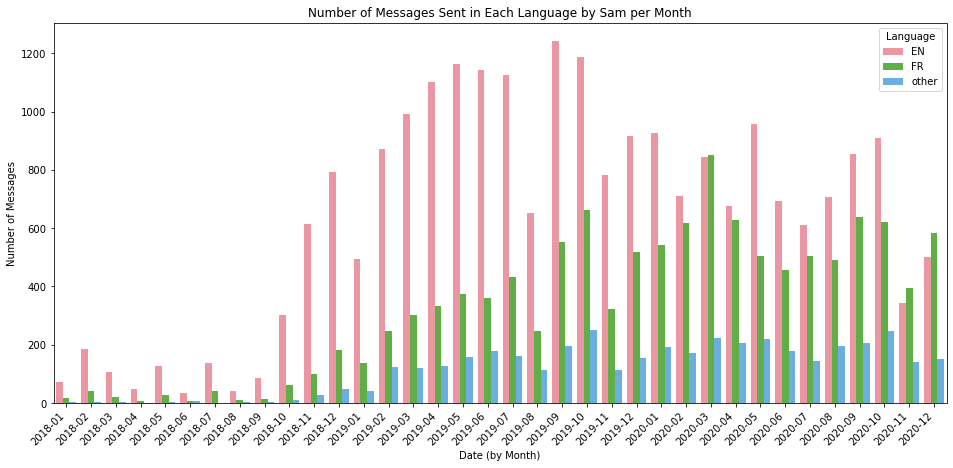

In [102]:
df_lang_agg = agg_by_month(df_lang, ['name', 'lang'], {'lang': ['count']})
celine_agg = df_lang_agg[df_lang_agg['name'] == CELINE]
sam_agg = df_lang_agg[df_lang_agg['name'] == SAM]

def plot_sns_language(data, name):
    plt.figure(figsize=(16,7))
    bplot = sns.barplot(y=('lang', 'count'), hue=('lang', ''), x='datetime', data=data)
    bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45, horizontalalignment='right')
    bplot.set_title('Number of Messages Sent in Each Language by {} per Month'.format(name))
    bplot.set_ylabel('Number of Messages')
    bplot.set_xlabel('Date (by Month)')
    bplot.legend(title='Language')
    
plot_sns_language(celine_agg, 'Celine')
plot_sns_language(sam_agg, 'Sam')

# Emojis
Sam and Celine love using a wide range of emojis,  using the 🤗 emoji. Howevever, Celine loves to laugh and make fun of Sam, so her top favourite emojis to use are: 😂, 😝, 🤗. Sam loves hugs, being happy and thinks a lot, his favourite emojis are: 🤗, 😁, 🤔.

In [122]:
celine_emoji = df[df['name'] == CELINE]
sam_emoji = df[df['name'] == SAM]

c_emoji_sum = adv.extract_emoji(celine_emoji['msg'])
s_emoji_sum = adv.extract_emoji(sam_emoji['msg'])
emoji_sum = adv.extract_emoji(df['msg'])

In [149]:
def top_emoji_percent(emoji_sum):
    top_emoji = emoji_sum['top_emoji'][0:10]
    emoji_total = emoji_sum['overview']['num_emoji']
    
    top_percent = [(e, round(c/emoji_total*100, 2), c) for e, c in top_emoji]
    return top_percent

In [150]:
top_emoji_percent(s_emoji_sum)

[('🤗', 14.3, 2403),
 ('😁', 8.56, 1438),
 ('🤔', 5.93, 996),
 ('😜', 5.59, 939),
 ('😤', 5.44, 915),
 ('😝', 4.75, 799),
 ('😂', 4.35, 731),
 ('😋', 2.83, 476),
 ('😉', 2.67, 449),
 ('😌', 2.64, 444)]

In [151]:
top_emoji_percent(c_emoji_sum)

[('😂', 16.98, 2028),
 ('😝', 12.82, 1531),
 ('🤗', 6.07, 725),
 ('😭', 5.15, 615),
 ('😮', 4.93, 589),
 ('😤', 4.86, 580),
 ('😁', 3.41, 407),
 ('😋', 3.17, 379),
 ('😱', 2.93, 350),
 ('😊', 2.83, 338)]

In [153]:
top_emoji_percent(emoji_sum)

[('🤗', 10.88, 3128),
 ('😂', 9.6, 2759),
 ('😝', 8.1, 2330),
 ('😁', 6.42, 1845),
 ('😤', 5.2, 1495),
 ('🤔', 4.49, 1292),
 ('😜', 4.14, 1190),
 ('😋', 2.97, 855),
 ('😭', 2.76, 793),
 ('😮', 2.69, 773)]